<a href="https://colab.research.google.com/github/JohnnyRhymes/Johnny/blob/main/Power_Output_Hybrid_Deep_Learning_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this research, several advanced models were used to predict the power output of Floating Offshore Wind Turbines (FOWTs). These models include machine learning and deep learning approaches, like Support Vector Regression (SVR), Random Forest, Gradient Boosting Machine (GBM), Long Short-Term Memory (LSTM), and Convolutional Neural Network (CNN). The goal was to forecast how much power these turbines would generate under various weather conditions, such as wind speed, temperature, and humidity.

# Why Do We Need These Predictions?
Imagine running a wind turbine like running a business. Knowing how much power the turbine will generate is like predicting your income. If we can accurately predict how much power the turbine will produce, it allows energy companies to plan better: scheduling maintenance, selling energy in advance, or knowing when the turbines might underperform. It's a critical part of ensuring that wind power can efficiently contribute to the energy grid.

# What Do the Results Mean?
The results from the different models are compared using metrics like:

1. Root Mean Square Error (RMSE): This measures how far the predictions are from the actual power output. Lower values are better because it means the model is making more accurate predictions.
2. Mean Absolute Error (MAE): This is another way of measuring prediction accuracy by looking at the average difference between predicted and actual power. Again, the smaller the value, the better.
3. R² (Coefficient of Determination): This tells us how well the model explains the variation in the actual power output. If R² is close to 1, it means the model's predictions are very accurate.

# How These Metrics Matter in Real Life:
For Energy Providers: These metrics help them understand how reliable your predictions are. If your error metrics (like MAE or RMSE) are low, it means the energy provider can trust your model to supply accurate forecasts, which is critical for managing energy production and avoiding power shortages or surpluses.


# Import Libraries and Upload Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from IPython.display import display, HTML

# Load the dataset
from google.colab import files
uploaded = files.upload()

# Assuming the file name is knowsthorpe_gate_data.csv
data = pd.read_csv('knowsthorpe_gate.csv')

Saving knowsthorpe_gate.csv to knowsthorpe_gate.csv


In [ ]:
import tensorflow as tf
import random
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Power Simulation and Head and Tail of Data frame

In [ ]:
# Convert 'Date' column to datetime
if '#Date and Time' in data.columns:
    data['#Date and Time'] = pd.to_datetime(data['#Date and Time'], format='%m/%d/%Y %H:%M')

# Power Output Simulation

def air_density(temperature, pressure=101325, relative_humidity=0):
    """
    Calculate air density based on temperature, pressure, and relative humidity.

    temperature: in Celsius
    pressure: in Pascal (default is sea level standard pressure)
    relative_humidity: as a fraction (0-1)
    """
    T = temperature + 273.15  # Convert to Kelvin
    Rd = 287.05  # Specific gas constant for dry air, J/(kg·K)
    Rv = 461.495  # Specific gas constant for water vapor, J/(kg·K)

    # Saturation vapor pressure
    es = 611.2 * np.exp(17.67 * temperature / (temperature + 243.5))

    # Vapor pressure
    e = relative_humidity * es

    # Air density
    rho = (pressure - e) / (Rd * T) + e / (Rv * T)

    return rho

def wind_power(wind_speed, temperature, rotor_diameter, pressure=101325, relative_humidity=0):
    """
    Calculate wind power based on wind speed, temperature, and turbine characteristics.

    wind_speed: in m/s
    temperature: in Celsius
    rotor_diameter: in meters
    pressure: in Pascal (default is sea level standard pressure)
    relative_humidity: as a fraction (0-1)
    """
    # Typical wind turbine characteristics
    cut_in_speed = 3.0  # m/s
    rated_speed = 12.0  # m/s
    cut_out_speed = 25.0  # m/s
    Cp = 0.4  # A typical value for modern wind turbines

    if wind_speed < cut_in_speed or wind_speed > cut_out_speed:
        return 0

    rho = air_density(temperature, pressure, relative_humidity)
    A = np.pi * (rotor_diameter / 2)**2

    # Linear interpolation between cut-in speed and rated speed
    if wind_speed < rated_speed:
        power_ratio = (wind_speed - cut_in_speed) / (rated_speed - cut_in_speed)
    else:
        power_ratio = 1.0

    P = 0.5 * rho * A * wind_speed**3 * Cp * power_ratio

    # Convert to kW
    return min(P / 1000, 4000)  # Assuming a 3 MW turbine as maximum

# Apply the function to your dataframe
data['Power Output (kW)'] = data.apply(lambda row: wind_power(row['Wind Spd 12m m/s'],
                                                              row['Temp 8m Deg C'],
                                                              120,  # Assume 120m rotor diameter
                                                              relative_humidity=row['Rel Hum %']/100), axis=1)

# Display the first few rows of the updated dataset
display(HTML(data.head().to_html(classes='table table-striped table-hover')))
# Display the last few rows of the updated dataset
display(HTML(data.tail().to_html(classes='table table-striped table-hover')))

,#Date and Time,Wind Dir 12m,Wind Spd 12m m/s,Wind STD,Temp 8m Deg C,Temp Diff 2m,Rel Hum %,Power Output (kW)
0,2010-01-01 00:15:00,9.37,2.428,14.59,0.267,-0.262,86.8999,0.000000
1,2010-01-01 00:30:00,354.20,3.190,14.60,0.388,-0.300,87.3999,1.996254
2,2010-01-01 00:45:00,343.80,3.234,17.81,0.361,-0.263,87.3999,2.561950
3,2010-01-01 01:00:00,350.90,3.153,15.52,0.246,-0.234,87.5000,1.553056
4,2010-01-01 01:15:00,341.90,3.204,18.04,0.207,-0.173,87.2999,2.173191


,#Date and Time,Wind Dir 12m,Wind Spd 12m m/s,Wind STD,Temp 8m Deg C,Temp Diff 2m,Rel Hum %,Power Output (kW)
140252,2013-12-31 23:15:00,166.8,4.641,13.28,5.30800,NaN,82.7000,52.117908
140253,2013-12-31 23:30:00,162.7,4.097,13.36,5.43999,0.141,81.8999,23.957586
140254,2013-12-31 23:45:00,164.7,4.048,13.76,5.55499,0.099,81.3999,22.066826
140255,2014-01-01 00:00:00,155.3,3.869,12.29,5.51900,0.064,82.1000,15.977979
140256,2014-01-01 00:15:00,155.3,3.918,10.96,5.27499,NaN,83.7000,17.543630


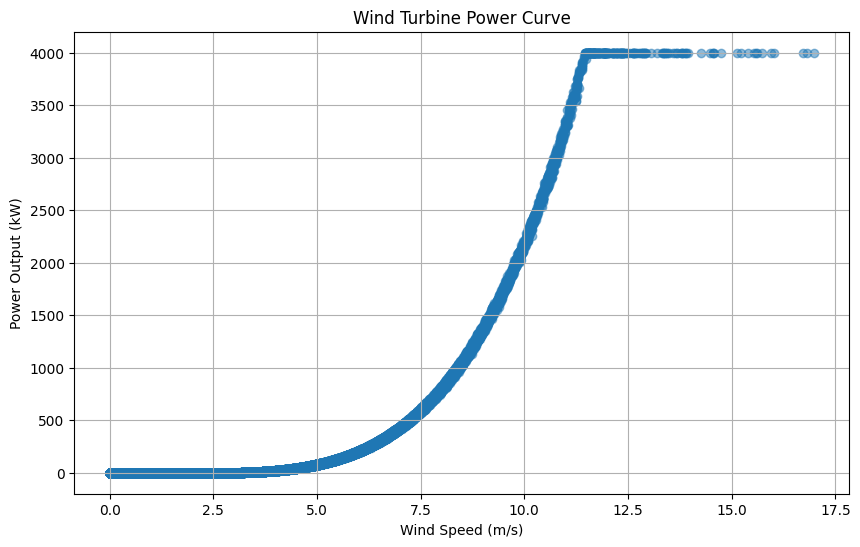

In [ ]:
# prompt: plot a power curve. This curve should clearly demonstrates the cubic relationship in the lower wind speed range, the plateau at rated power, and the cut-out at high wind speed

# Create a scatter plot with wind speed on the x-axis and power output on the y-axis
plt.figure(figsize=(10, 6))
plt.scatter(data['Wind Spd 12m m/s'], data['Power Output (kW)'], alpha=0.5)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Wind Turbine Power Curve')
plt.grid(True)
plt.savefig('Wind Power Curve')
plt.show()


# Top 10 Highest Power Output

In [ ]:
# Find the highest power output
max_power = data['Power Output (kW)'].max()
print(f"Highest power output: {max_power:.2f} kW")

# Define a threshold for "close to highest" (e.g., within 5% of max)
threshold = 0.95 * max_power

# Find all instances where power output is close to or at the maximum
high_power_instances = data[data['Power Output (kW)'] >= threshold]

print(f"\nNumber of instances with power output >= {threshold:.2f} kW: {len(high_power_instances)}")

# Display the top 10 highest power output instances
print("\nTop 10 highest power output instances:")
display(HTML(high_power_instances.sort_values('Power Output (kW)', ascending=False).head(10).to_html(classes='table table-striped table-hover')))

Highest power output: 4000.00 kW

Number of instances with power output >= 3800.00 kW: 227

Top 10 highest power output instances:


,#Date and Time,Wind Dir 12m,Wind Spd 12m m/s,Wind STD,Temp 8m Deg C,Temp Diff 2m,Rel Hum %,Power Output (kW)
137720,2013-12-05 14:15:00,285.8,14.55,14.08000,9.17999,0.147,55.0099,4000.0
137721,2013-12-05 14:30:00,293.4,11.63,14.10000,8.82999,-0.037,55.5800,4000.0
137722,2013-12-05 14:45:00,294.9,11.96,15.03000,8.57999,-0.020,48.1000,4000.0
138643,2013-12-15 05:00:00,254.3,12.23,9.25999,9.59000,0.026,64.1200,4000.0
138644,2013-12-15 05:15:00,255.1,11.48,9.09999,9.34999,-0.027,65.7899,4000.0
139785,2013-12-27 02:30:00,150.7,11.93,10.45000,6.04900,-0.058,89.7999,4000.0
41619,2011-03-10 13:00:00,263.1,12.15,18.24000,10.58000,-0.261,61.2599,4000.0
41620,2011-03-10 13:15:00,265.5,11.72,16.72000,9.64999,-0.291,64.1599,4000.0
41622,2011-03-10 13:45:00,262.5,12.03,16.38000,10.41000,-0.257,57.3900,4000.0
43625,2011-03-31 10:30:00,252.2,13.49,13.33000,15.48000,-0.108,56.5600,4000.0


In [ ]:
# prompt: Statistical summary of key variables

# Statistical summary of key variables
print(data[['Wind Spd 12m m/s', 'Temp 8m Deg C', 'Rel Hum %', 'Power Output (kW)']].describe())


       Wind Spd 12m m/s  Temp 8m Deg C      Rel Hum %  Power Output (kW)
count     140067.000000  137306.000000  139948.000000      139228.000000
mean           3.229555      10.269890      76.234796          81.143140
std            1.933969       5.940665      14.956188         300.855984
min            0.000000      -8.629990      17.250000           0.000000
25%            1.780000       5.887990      67.610000           0.000000
50%            2.866000      10.390000      78.899900           0.000000
75%            4.320000      14.490000      87.899900          32.516065
max           16.990000      30.820000      99.500000        4000.000000


# Missing Values

In [ ]:
# Check for missing values
print(data.isnull().sum())

#Date and Time          0
Wind Dir 12m          189
Wind Spd 12m m/s      190
Wind STD              192
Temp 8m Deg C        2951
Temp Diff 2m         5283
Rel Hum %             309
Power Output (kW)    1029
dtype: int64


# Mean Imputation

In [ ]:
numeric_columns = data.select_dtypes(include=np.number).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())
data.isnull().sum()

,0
#Date and Time,0
Wind Dir 12m,0
Wind Spd 12m m/s,0
Wind STD,0
Temp 8m Deg C,0
Temp Diff 2m,0
Rel Hum %,0
Power Output (kW),0


# Outlier Detection and Removal

<ipython-input-15-733bbb5eb70d>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


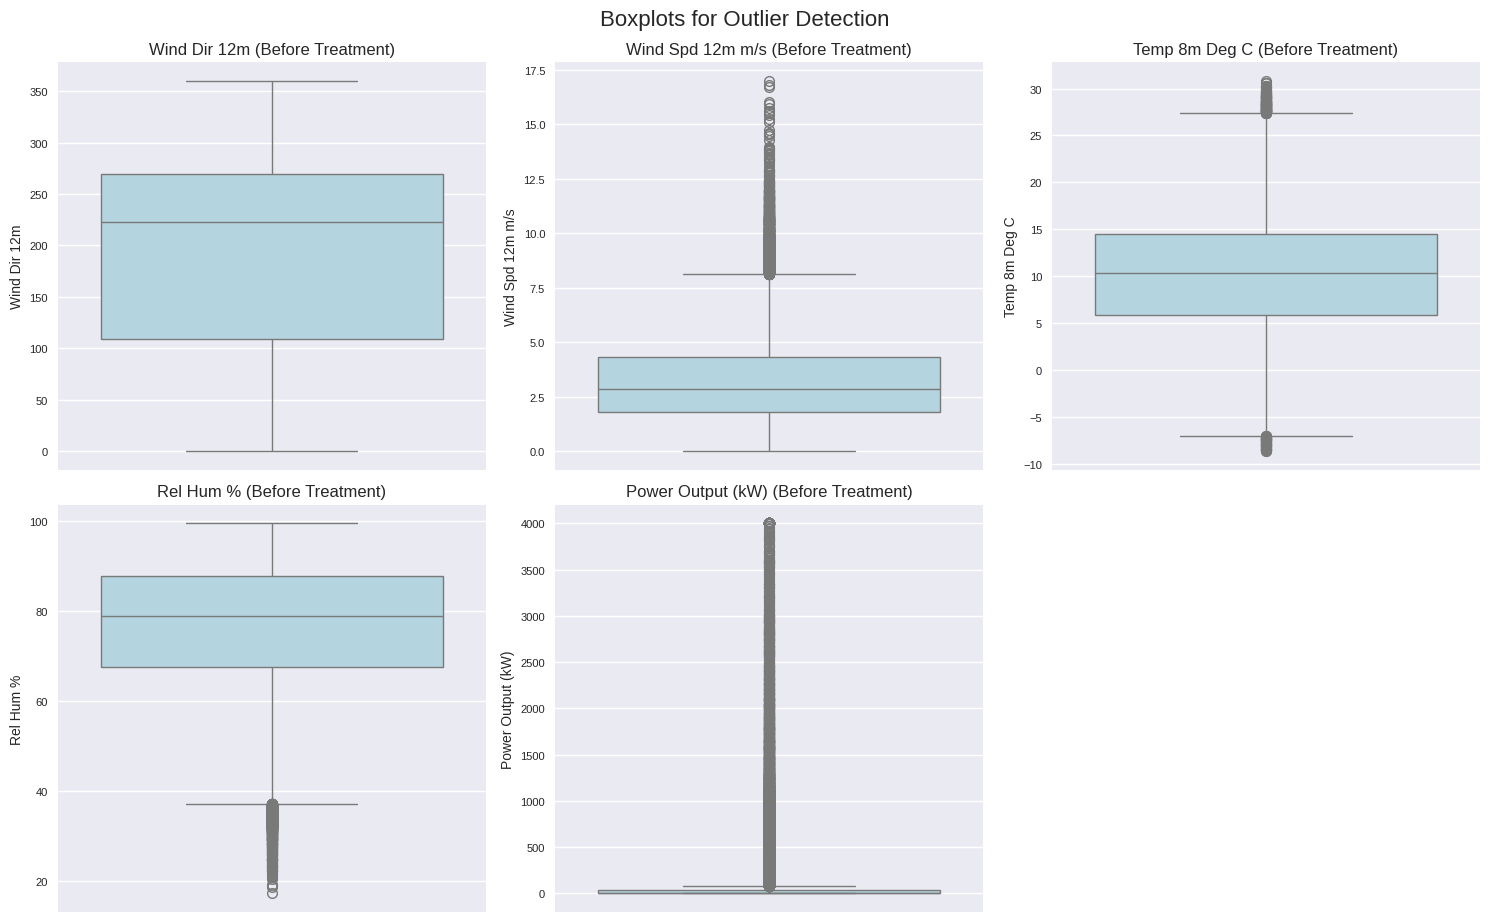

Number of outliers in Wind Dir 12m: 0
Number of outliers in Wind Spd 12m m/s: 2859
Number of outliers in Temp 8m Deg C: 340
Number of outliers in Rel Hum %: 1683
Number of outliers in Power Output (kW): 22958


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Columns to check for outliers
columns_to_check = ['Wind Dir 12m', 'Wind Spd 12m m/s', 'Temp 8m Deg C', 'Rel Hum %', 'Power Output (kW)']

# Set the style for better-looking plots
plt.style.use('seaborn')

# Create a 2x3 subplot layout for outlier detection
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Create boxplots for outlier detection
for ax, column in zip(axes, columns_to_check):
    sns.boxplot(y=data[column], ax=ax, color='lightblue')
    ax.set_title(f'{column} (Before Treatment)', fontsize=12)
    ax.set_ylabel(column, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)

# Remove the last subplot (which is empty)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.suptitle('Boxplots for Outlier Detection', fontsize=16, y=1.02)
plt.savefig('Box Plot for Outlier Detection')  # Save the plot
plt.show()

# Identify outliers
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Print number of outliers for each column
for column in columns_to_check:
    outliers = identify_outliers(data, column)
    print(f"Number of outliers in {column}: {len(outliers)}")

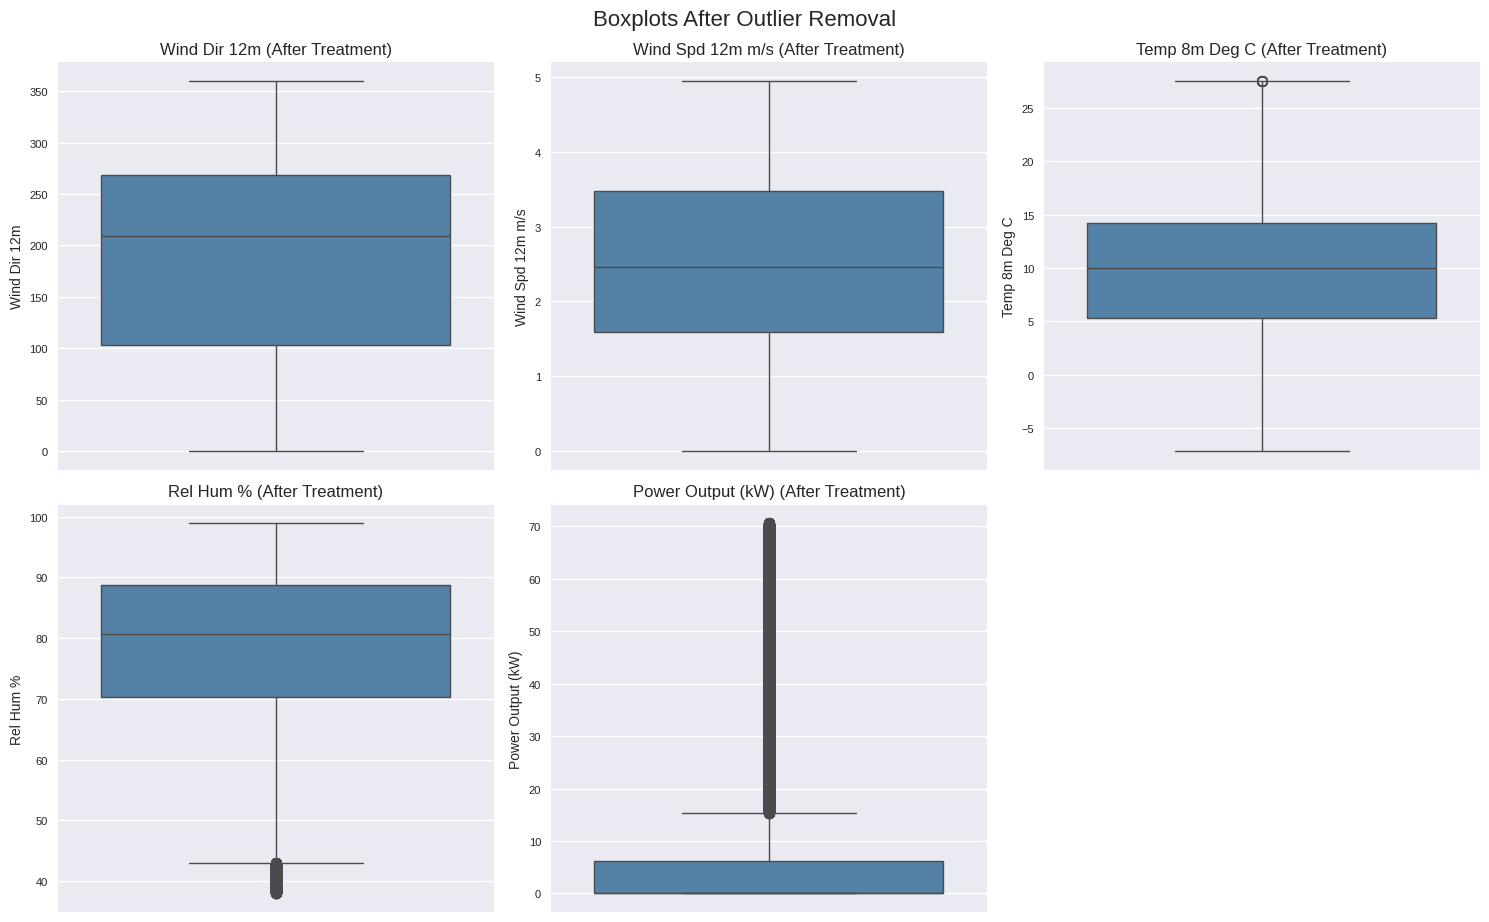

Original dataset size: 140257
Dataset size after outlier removal: 110689
Number of rows removed: 29568


In [ ]:
# Function to remove outliers
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Remove outliers
data_no_outliers = remove_outliers(data, columns_to_check)

# Create a 2x3 subplot layout for after outlier removal
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Create boxplots after outlier removal
for ax, column in zip(axes, columns_to_check):
    sns.boxplot(y=data_no_outliers[column], ax=ax, color='steelblue')
    ax.set_title(f'{column} (After Treatment)', fontsize=12)
    ax.set_ylabel(column, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)

# Remove the last subplot (which is empty)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.suptitle('Boxplots After Outlier Removal', fontsize=16, y=1.02)
plt.savefig('Boxplots After Outlier Removal')  # Save the plot
plt.show()

# Print summary of data removal
print("Original dataset size:", len(data))
print("Dataset size after outlier removal:", len(data_no_outliers))
print("Number of rows removed:", len(data) - len(data_no_outliers))

# Correlation Analysis Heatmap

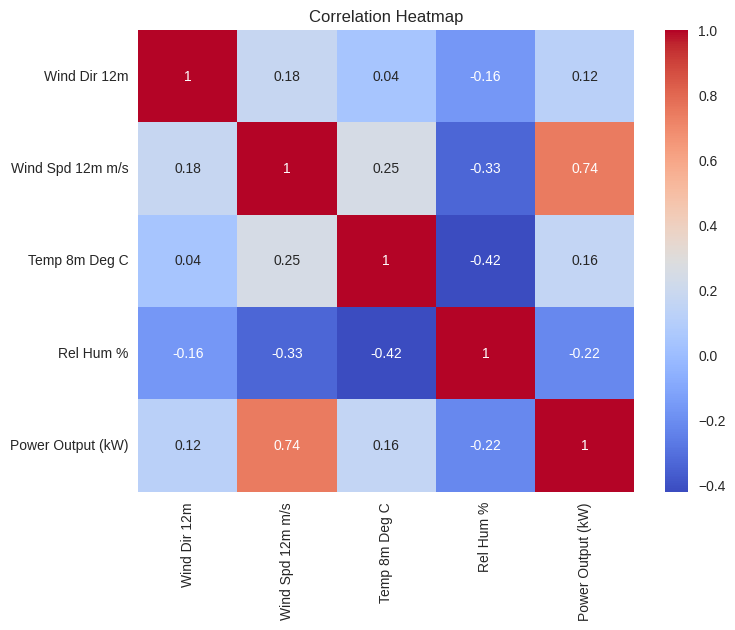

In [ ]:
# Correlation Analysis
correlation_matrix = data_no_outliers[columns_to_check].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('Correlation Heatmap')  # Save the plot
plt.show()

# Time series Visualisation

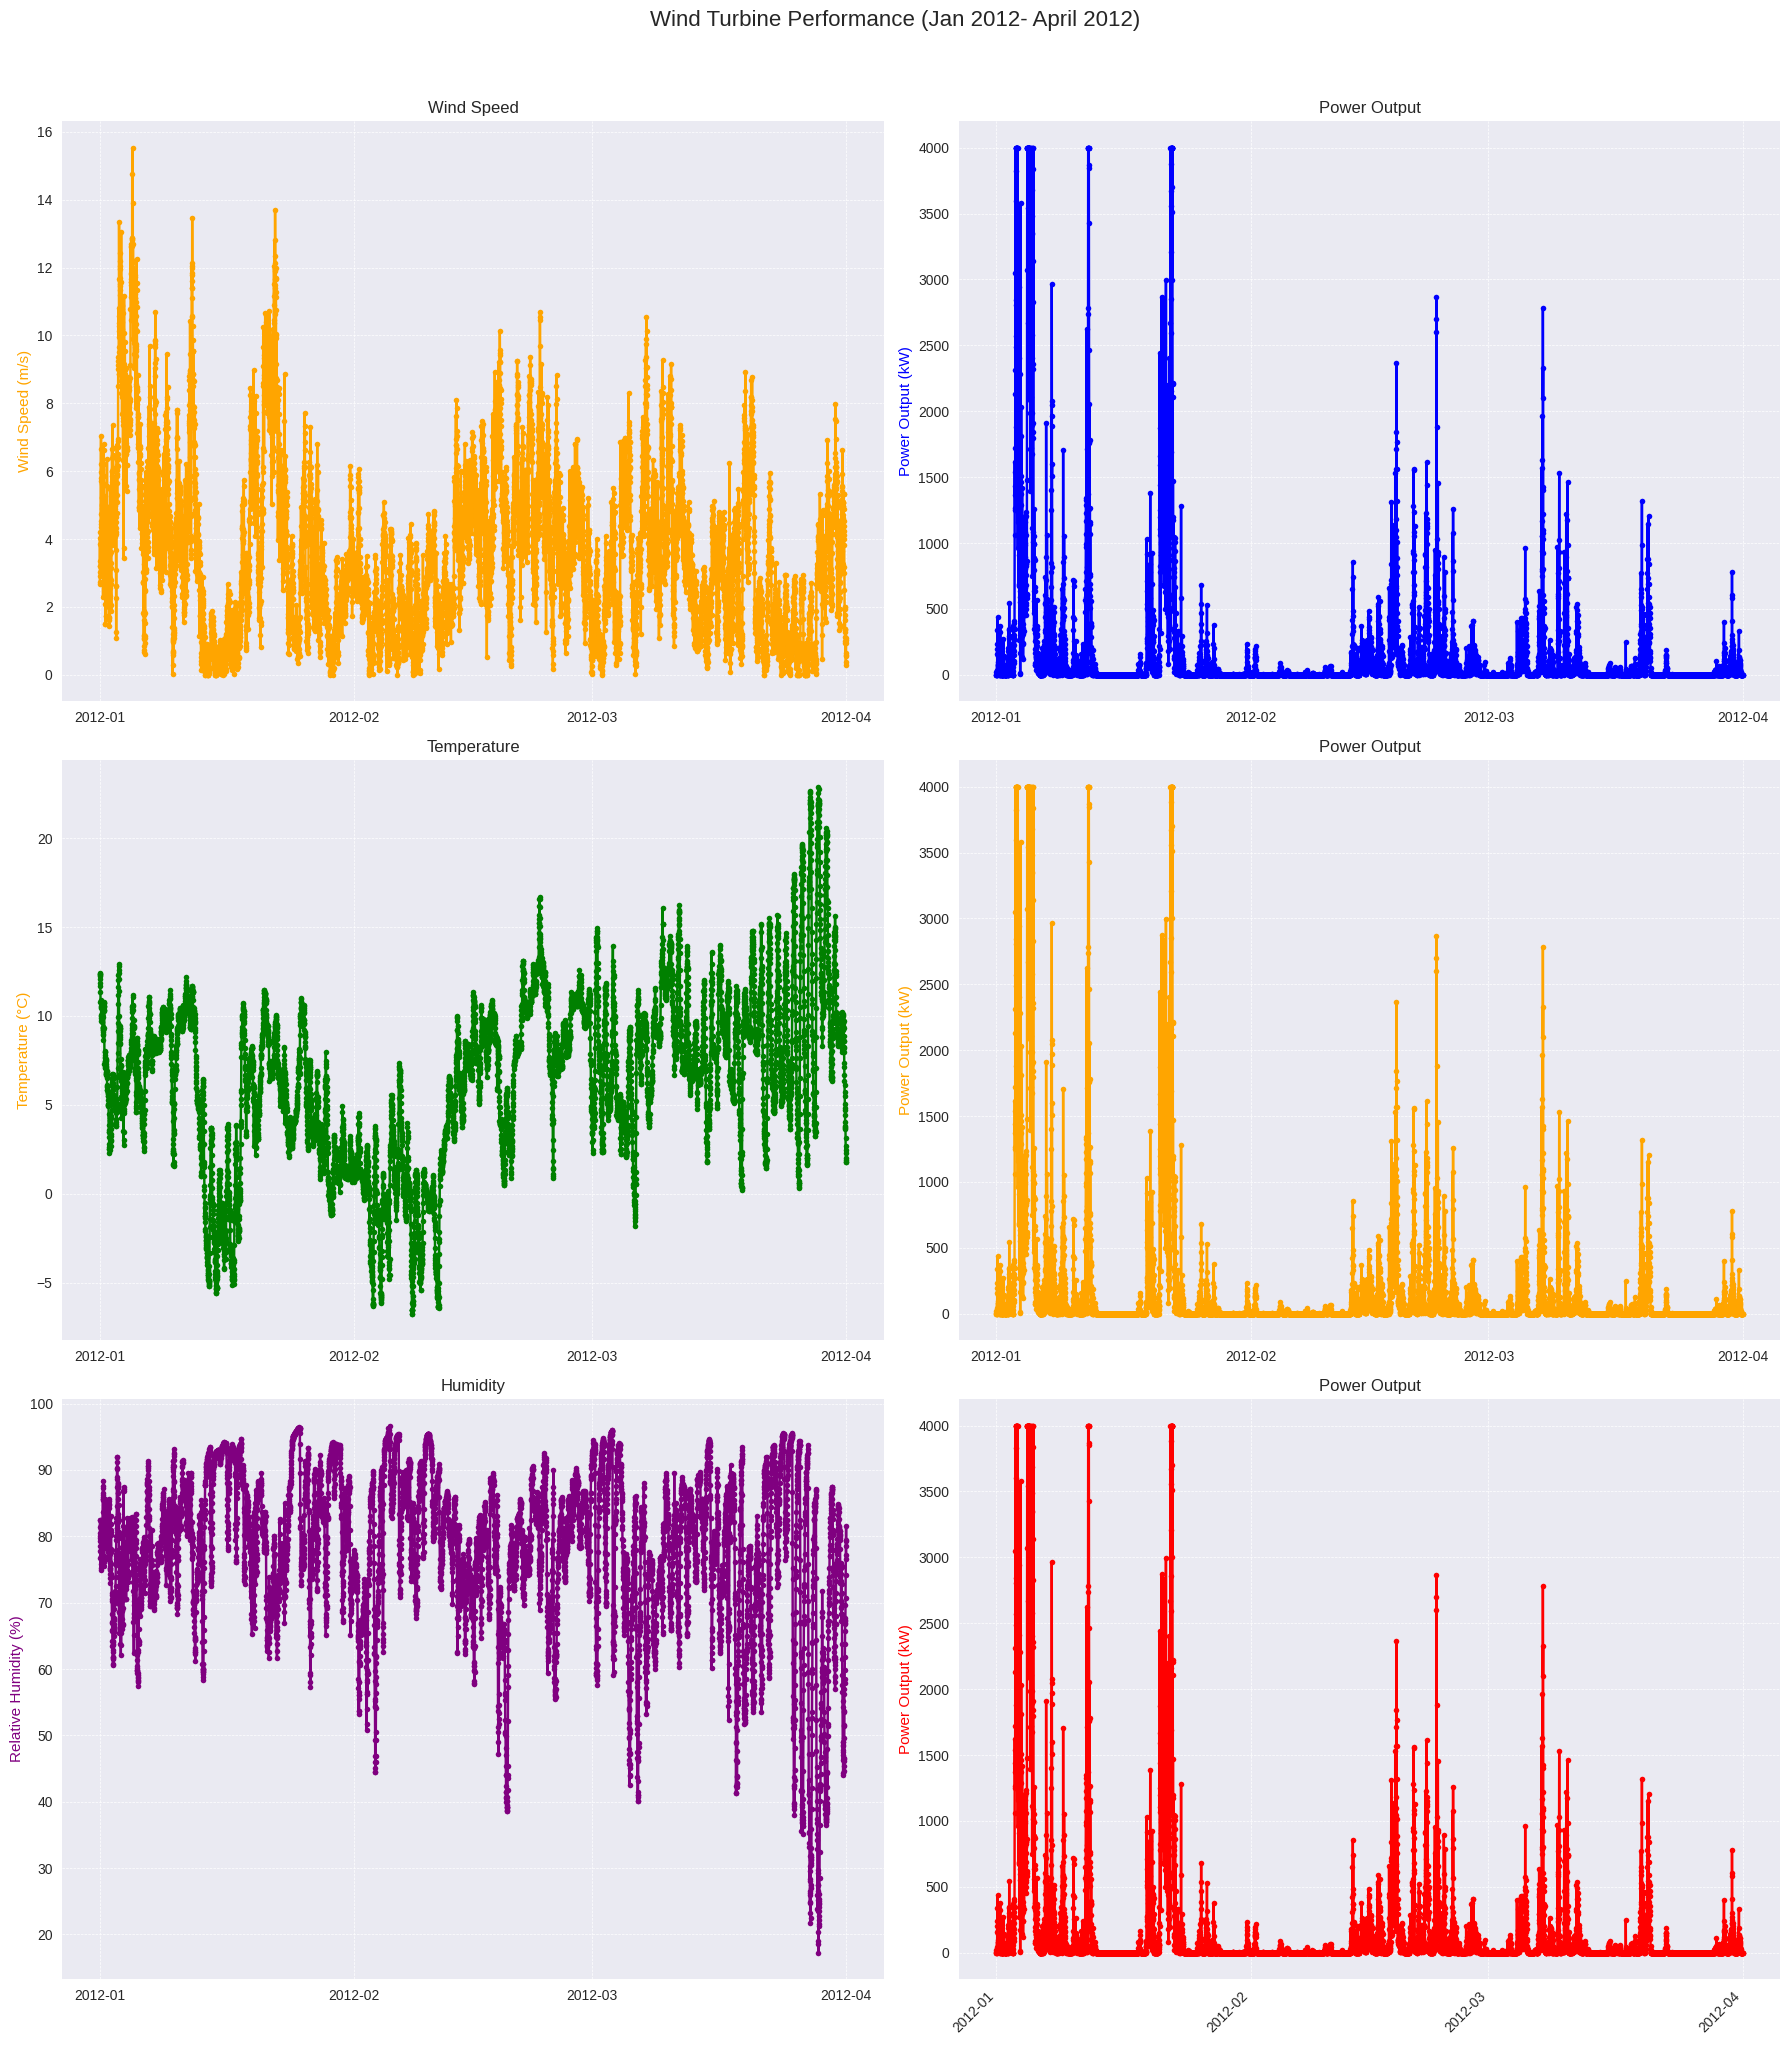

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

def plot_time_series(data, start_date, end_date, title):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    data_period = data[(data['#Date and Time'] >= start_date) & (data['#Date and Time'] < end_date)]

    if data_period.empty:
        print(f"No data available for the period {start_date} to {end_date}")
        return

    fig, axs = plt.subplots(3, 2, figsize=(18, 20))
    fig.suptitle(title, fontsize=16, y=1.02)

    # Wind Speed
    axs[0, 0].plot(data_period['#Date and Time'], data_period['Wind Spd 12m m/s'], color='orange', marker='o', linestyle='-', markersize=4)
    axs[0, 0].set_ylabel('Wind Speed (m/s)', color='orange')
    axs[0, 0].set_title('Wind Speed')

    # Power Output (corresponding to Wind Speed)
    axs[0, 1].plot(data_period['#Date and Time'], data_period['Power Output (kW)'], color='blue', marker='o', linestyle='-', markersize=4)
    axs[0, 1].set_ylabel('Power Output (kW)', color='blue')
    axs[0, 1].set_title('Power Output')

    # Temperature
    axs[1, 0].plot(data_period['#Date and Time'], data_period['Temp 8m Deg C'], color='green', marker='o', linestyle='-', markersize=4)
    axs[1, 0].set_ylabel('Temperature (°C)', color='orange')
    axs[1, 0].set_title('Temperature')

    # Power Output (corresponding to Temperature)
    axs[1, 1].plot(data_period['#Date and Time'], data_period['Power Output (kW)'], color='orange', marker='o', linestyle='-', markersize=4)
    axs[1, 1].set_ylabel('Power Output (kW)', color='orange')
    axs[1, 1].set_title('Power Output')

    # Humidity
    axs[2, 0].plot(data_period['#Date and Time'], data_period['Rel Hum %'], color='purple', marker='o', linestyle='-', markersize=4)
    axs[2, 0].set_ylabel('Relative Humidity (%)', color='purple')
    axs[2, 0].set_title('Humidity')

    # Power Output (corresponding to Humidity)
    axs[2, 1].plot(data_period['#Date and Time'], data_period['Power Output (kW)'], color='red', marker='o', linestyle='-', markersize=4)
    axs[2, 1].set_ylabel('Power Output (kW)', color='red')
    axs[2, 1].set_title('Power Output')

    for ax in axs.flat:
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        # Correct indentation for the following line
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('Time_Series Plot')  # Save the plot
    plt.tight_layout
    plt.show()

# Plot for a 6-month period in 2011
plot_time_series(data, '2012-01-01', '2012-04-01', 'Wind Turbine Performance (Jan 2012- April 2012)')

In [ ]:
# Normalization
scaler = StandardScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(data_no_outliers[columns_to_check]), columns=columns_to_check)

# Prepare data for modeling
X = normalized_data[['Wind Dir 12m', 'Wind Spd 12m m/s', 'Temp 8m Deg C', 'Rel Hum %']]
y = normalized_data['Power Output (kW)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Machine Learning Models (SVR, Random Forest and GBM)
These are advanced statistical methods. They analyze patterns in the weather data and try to predict the power output based on those patterns. They work well when there are clear relationships in the data, like the way wind speed affects turbine power.



In [ ]:
# Support Vector Regression
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

In [ ]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [ ]:

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return pd.DataFrame({'Model': [model_name], 'MAE': [mae], 'RMSE': [rmse], 'R2': [r2]})

results = pd.concat([
    evaluate_model(y_test, svr_pred, 'SVR'),
    evaluate_model(y_test, rf_pred, 'Random Forest'),
    evaluate_model(y_test, gb_pred, 'Gradient Boosting'),
    ])

# Display results
display(HTML(results.to_html(index=False, classes='table table-striped table-hover')))

Model,MAE,RMSE,R2
SVR,0.043904,0.052207,0.997302
Random Forest,0.000631,0.002155,0.999995
Gradient Boosting,0.003054,0.006659,0.999956


# Deep Learning Models (CNN, LSTM and GRU)
These models are more sophisticated because they can learn from time-based data. In the case of wind turbines, conditions like wind speed can change over time, and these models can understand how past weather conditions affect future power output. This makes them more powerful for predictions when the weather is very unpredictable or when relationships between variables are complex.

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Prepare data for CNN (reshape to [samples, time steps, features])
X_cnn = X.values.reshape((X.shape[0], X.shape[1], 1))
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_cnn.fit(X_train_cnn, y_train_cnn, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

cnn_pred = model_cnn.predict(X_test_cnn)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1727 - val_loss: 0.0374
Epoch 2/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0277 - val_loss: 0.0316
Epoch 3/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0220 - val_loss: 0.0284
Epoch 4/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0194 - val_loss: 0.0254
Epoch 5/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0178 - val_loss: 0.0228
Epoch 6/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0163 - val_loss: 0.0197
Epoch 7/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0151 - val_loss: 0.0190
Epoch 8/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0143 - val_loss: 0.0168
Epoch 9/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0135 - val_loss: 0.0159
Epoch 10/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0128 - val_loss: 0.0168
Epoch 11/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0124 - val_loss: 0.0152
Epoch 12/100
2214/2

In [ ]:
# Prepare data for LSTM (reshape to [samples, time steps, features])
X_lstm = X.values.reshape((X.shape[0], 1, X.shape[1]))
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X.shape[1])),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

lstm_pred = model_lstm.predict(X_test_lstm)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2689 - val_loss: 0.0011
Epoch 2/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.5899e-04 - val_loss: 1.8317e-04
Epoch 3/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1970e-04 - val_loss: 3.6910e-05
Epoch 4/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4.7853e-05 - val_loss: 2.8776e-05
Epoch 5/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.2862e-05 - val_loss: 2.3078e-05
Epoch 6/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 2.8943e-05 - val_loss: 1.3071e-05
Epoch 7/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.0632e-05 - val_loss: 7.5264e-06
Epoch 8/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.6872e-05 - val_loss: 8.3853e-06
Epoch 9/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.7153e-05 - val_loss: 1.3006e-05
Epoch 10/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.9110e-05 - val_loss: 4.7211e-06
Epoch 11/100
2214/2214 ━━━━━━━━━━━━━━

In [ ]:
from tensorflow.keras.layers import GRU

# Prepare data for GRU (reshape to [samples, time steps, features])
X_gru = X.values.reshape((X.shape[0], 1, X.shape[1]))
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y, test_size=0.2, random_state=42)

# Build the GRU model
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(1, X.shape[1])),
    Dense(1)
])

# Compile the model
model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
model_gru.fit(X_train_gru, y_train_gru, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions
gru_pred = model_gru.predict(X_test_gru)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2214/2214 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2322 - val_loss: 0.0010
Epoch 2/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 6.1654e-04 - val_loss: 1.4340e-04
Epoch 3/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.1915e-04 - val_loss: 5.3350e-05
Epoch 4/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.5754e-05 - val_loss: 8.1391e-05
Epoch 5/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.6745e-05 - val_loss: 1.4050e-04
Epoch 6/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 3.9641e-05 - val_loss: 1.7151e-05
Epoch 7/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.3909e-05 - val_loss: 9.6127e-06
Epoch 8/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3.4895e-05 - val_loss: 1.1197e-05
Epoch 9/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4.4222e-05 - val_loss: 3.8287e-05
Epoch 10/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.9970e-05 - val_loss: 6.4396e-05
Epoch 11/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 5s 2m

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return pd.DataFrame({'Model': [model_name], 'MAE': [mae], 'RMSE': [rmse], 'R2': [r2]})

results = pd.concat([
    evaluate_model(y_test, cnn_pred, 'CNN'),
    evaluate_model(y_test, lstm_pred, 'LSTM'),
    evaluate_model(y_test, gru_pred, 'GRU'),
])

# Display results
display(HTML(results.to_html(index=False, classes='table table-striped table-hover')))

Model,MAE,RMSE,R2
CNN,0.027822,0.066766,0.995587
LSTM,0.000714,0.001295,0.999998
GRU,0.000698,0.001172,0.999999


# Hybrid LSTM-GRU Model
This combines the strengths of two advanced models, LSTM and GRU, to handle both short-term and long-term changes in weather conditions. This hybrid approach leads to even better predictions because it captures a more complete picture of how the weather impacts the turbine over time.

In [ ]:


# Prepare data for hybrid LSTM-GRU model
X_hybrid = X.values.reshape((X.shape[0], 1, X.shape[1]))
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(X_hybrid, y, test_size=0.2, random_state=42)

# Build the hybrid LSTM-GRU model
model_hybrid = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X.shape[1])),
    GRU(50, activation='relu'),
    Dense(1)
])

# Compile the model
model_hybrid.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
model_hybrid.fit(X_train_hybrid, y_train_hybrid, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions
hybrid_pred = model_hybrid.predict(X_test_hybrid)



Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2214/2214 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.1640 - val_loss: 1.7370e-04
Epoch 2/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.8225e-04 - val_loss: 9.8342e-05
Epoch 3/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.3975e-04 - val_loss: 2.8978e-04
Epoch 4/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.4246e-04 - val_loss: 6.6480e-05
Epoch 5/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1362e-04 - val_loss: 4.4262e-05
Epoch 6/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1562e-04 - val_loss: 1.2506e-05
Epoch 7/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 5.0806e-05 - val_loss: 2.8497e-05
Epoch 8/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 9.7186e-05 - val_loss: 6.9950e-06
Epoch 9/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 9.3115e-05 - val_loss: 8.6186e-06
Epoch 10/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 8.9055e-05 - val_loss: 6.0311e-06
Epoch 11/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Evaluate the hybrid model
results_hybrid = evaluate_model(y_test, hybrid_pred, 'Hybrid LSTM-GRU')
display(HTML(results_hybrid.to_html(index=False, classes='table table-striped table-hover')))


Model,MAE,RMSE,R2
Hybrid LSTM-GRU,0.000318,0.000731,0.999999


# What Did We Find?
The hybrid LSTM-GRU model outperformed all other models. It had the lowest errors (RMSE and MAE) and the highest accuracy (R² of 0.999999, meaning near-perfect predictions). This suggests that combining different model techniques can provide more reliable forecasts than using a single method.

Wind speed (see model interbretability) emerged as the most important factor in predicting power output, which makes sense because wind turbines rely on wind to generate power. Other factors like temperature and humidity had smaller but still noticeable effects.

Given the success of your prediction models, particularly the hybrid LSTM-GRU model, here are some recommendations:

1. Adopt Hybrid Models for Future Predictions
* Since the hybrid LSTM-GRU model demonstrated the best performance in predicting Floating Offshore Wind Turbine (FOWT) power output, it is highly recommended that energy companies and researchers use hybrid deep learning models for future wind power predictions. This model effectively captures both short-term fluctuations and long-term trends, making it well-suited for the dynamic nature of offshore wind conditions.
2. Integrate Predictive Models into Real-Time Wind Farm Operations
With accurate power output predictions, wind farm operators should integrate these predictive models into their daily operations. This can help with:
* Energy scheduling: More precise forecasts enable better energy grid planning, ensuring that energy supply meets demand efficiently.
* Maintenance scheduling: Predictive insights can optimize maintenance schedules, reducing downtime and improving overall efficiency.
* Market participation: Accurate predictions can support energy trading by providing reliable estimates of future energy output.
3. Real-Time Control and Automation Systems
* Implement real-time control systems that leverage these predictive models to adjust the turbine settings automatically. Such systems could optimize the turbine's performance by adjusting blade angles or yaw positions based on predicted wind conditions, maximizing efficiency.
4. Invest in High-Performance Computing Resources
* Given that hybrid models like LSTM-GRU require substantial computational power, it is recommended that wind energy companies invest in high-performance computing infrastructure. This will ensure that the models can be run efficiently, providing near-real-time predictions without delays.
5. Collaborate with Industry for Real-World Data Validation
* To further improve the accuracy and robustness of the model, partnerships with FOWT operators can be established to gather real-world turbine data. This collaboration will help validate the predictive models in operational settings, ensuring their applicability and reliability in practical scenarios.
6. Use Prediction Models for Investment and Planning Decisions
* Wind energy developers and investors can use the insights from these predictive models to make informed decisions on where to locate new floating offshore wind farms. Areas with consistent, predictable wind patterns can be identified, reducing financial risk and optimizing energy yield.

# Error Analysis of Each Model

In [ ]:
#Error analysis  discussing where and why the models might be failing. Included all the models  this time around


# Error Analysis

# Function to plot residuals
def plot_residuals(y_true, y_pred, model_name):
    # Convert y_pred to a NumPy array if it's a Series
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.to_numpy()

    residuals = y_true - y_pred.flatten()
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred.flatten(), y=residuals)
    plt.title(f'Residual Plot for {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.savefig('Error Analysis')  # Save the plot
    plt.show()

# Plot residuals for all models
plot_residuals(y_test, svr_pred, 'SVR')
plot_residuals(y_test, rf_pred, 'Random Forest')
plot_residuals(y_test, gb_pred, 'Gradient Boosting')
plot_residuals(y_test_cnn, cnn_pred, 'CNN')
plot_residuals(y_test_lstm, lstm_pred, 'LSTM')
plot_residuals(y_test_gru, gru_pred, 'GRU')
plot_residuals(y_test_hybrid, hybrid_pred, 'Hybrid LSTM-GRU')

# Example of analyzing specific cases:
# (This is a simplified example, you might need to adapt it based on your data and model)
error_df = pd.DataFrame({'Actual': y_test, 'Predicted': hybrid_pred.flatten(), 'Residuals': y_test - hybrid_pred.flatten()})
error_df['Absolute_Residuals'] = abs(error_df['Residuals'])
top_errors = error_df.sort_values(by='Absolute_Residuals', ascending=False).head(10)

# Print or visualize the top errors to understand the context of the failures
print("Top 10 Errors:")
display(top_errors)

# ... (further analysis and visualizations as needed)


# Comparison of Best Performing Model

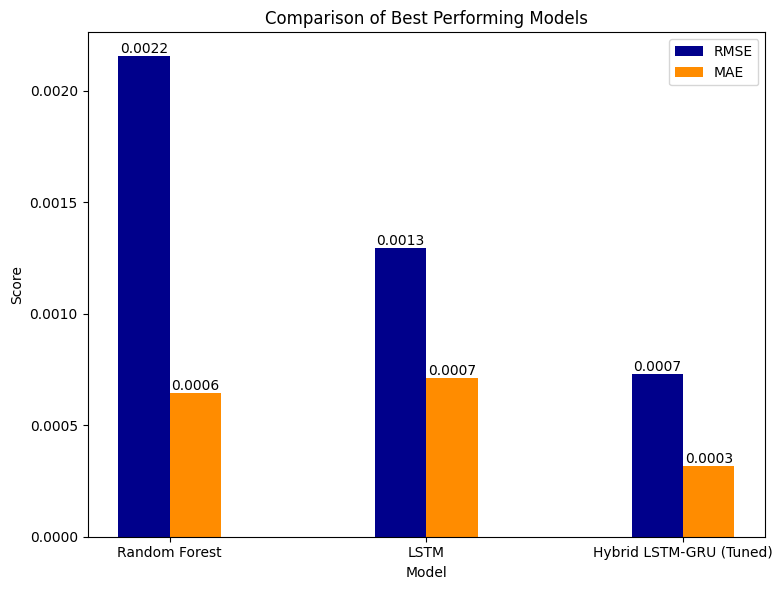

In [ ]:
import matplotlib.pyplot as plt

# Create a dictionary to store the results
results = {
    'Model': ['Random Forest', 'LSTM', 'Hybrid LSTM-GRU (Tuned)'],
    'RMSE': [0.002155, 0.001295, 	0.000731],
    'MAE': [0.000643, 0.000503, 0.000318]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(results)

# Set the width of the bars
bar_width = 0.02

# Calculate the x positions for the bars
x_pos = [0, 0.1, 0.2]

# Plot the bars
fig, ax = plt.subplots(figsize=(8, 6))
bars_rmse = ax.bar(x_pos, df['RMSE'], width=bar_width, label='RMSE', color='darkblue')
bars_mae = ax.bar([x + bar_width for x in x_pos], df['MAE'], width=bar_width, label='MAE', color='darkorange')

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Comparison of Best Performing Models')
ax.set_xticks([x + bar_width / 2 for x in x_pos])
ax.set_xticklabels(df['Model'])
ax.legend()

# Add the actual scores on the bars
for bar in bars_rmse + bars_mae:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom')

# Adjust the layout
plt.tight_layout()
plt.savefig('Bar Plot')  # Save the plot
plt.show()


# Hybrid Model Interpretability


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

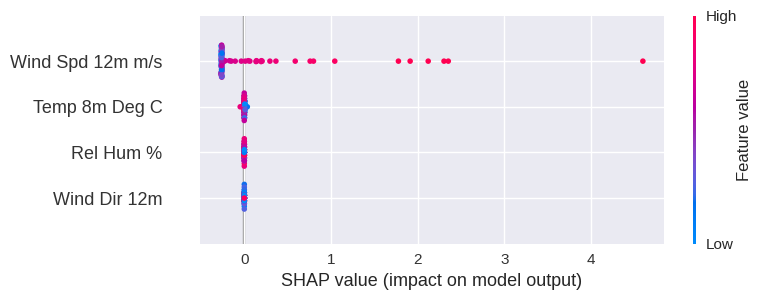

In [ ]:
import shap
import numpy as np

# Flatten the input data for SHAP to 2D (samples, features)
X_sample_flat = X_sample.reshape(X_sample.shape[0], X_sample.shape[2])

# Define a wrapper function to predict using the hybrid model
def hybrid_model_predict(data):
    # Reshape data back to the required 3D shape for the LSTM-GRU model (samples, time_steps, features)
    data = data.reshape((data.shape[0], 1, data.shape[1]))  # Reshape back to (samples, time_steps, features)
    return model_hybrid.predict(data)

# Create an explainer object for the hybrid model using KernelExplainer
explainer = shap.KernelExplainer(hybrid_model_predict, X_sample_flat)

# Calculate SHAP values for the sample data
shap_values = explainer.shap_values(X_sample_flat)

# Check if shap_values is a list, and convert it to a NumPy array if necessary
if isinstance(shap_values, list):
    shap_values = np.array(shap_values)

# Ensure shap_values is a 2D array (samples, features)
if shap_values.ndim == 3:
    shap_values = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])

# Check if shap_values shape matches X_sample_flat shape (features must align)
print("SHAP Values Shape:", np.array(shap_values).shape)
print("X_sample_flat Shape:", X_sample_flat.shape)

plt.savefig('Shap')  # Save the plot
# Plot the SHAP values
shap.summary_plot(shap_values, X_sample_flat, feature_names=['Wind Dir 12m', 'Wind Spd 12m m/s', 'Temp 8m Deg C', 'Rel Hum %'])

# What Did We Find?
The hybrid LSTM-GRU model outperformed all other models. It had the lowest errors (RMSE and MAE) and the highest accuracy (R² of 0.999999, meaning near-perfect predictions). This suggests that combining different model techniques can provide more reliable forecasts than using a single method.

Wind speed (see model interbretability) emerged as the most important factor in predicting power output, which makes sense because wind turbines rely on wind to generate power. Other factors like temperature and humidity had smaller but still noticeable effects.

Given the success of your prediction models, particularly the hybrid LSTM-GRU model, here are some recommendations:

1. Adopt Hybrid Models for Future Predictions
* Since the hybrid LSTM-GRU model demonstrated the best performance in predicting Floating Offshore Wind Turbine (FOWT) power output, it is highly recommended that energy companies and researchers use hybrid deep learning models for future wind power predictions. This model effectively captures both short-term fluctuations and long-term trends, making it well-suited for the dynamic nature of offshore wind conditions.
2. Integrate Predictive Models into Real-Time Wind Farm Operations
With accurate power output predictions, wind farm operators should integrate these predictive models into their daily operations. This can help with:
* Energy scheduling: More precise forecasts enable better energy grid planning, ensuring that energy supply meets demand efficiently.
* Maintenance scheduling: Predictive insights can optimize maintenance schedules, reducing downtime and improving overall efficiency.
* Market participation: Accurate predictions can support energy trading by providing reliable estimates of future energy output.
3. Real-Time Control and Automation Systems
* Implement real-time control systems that leverage these predictive models to adjust the turbine settings automatically. Such systems could optimize the turbine's performance by adjusting blade angles or yaw positions based on predicted wind conditions, maximizing efficiency.
4. Invest in High-Performance Computing Resources
* Given that hybrid models like LSTM-GRU require substantial computational power, it is recommended that wind energy companies invest in high-performance computing infrastructure. This will ensure that the models can be run efficiently, providing near-real-time predictions without delays.
5. Collaborate with Industry for Real-World Data Validation
* To further improve the accuracy and robustness of the model, partnerships with FOWT operators can be established to gather real-world turbine data. This collaboration will help validate the predictive models in operational settings, ensuring their applicability and reliability in practical scenarios.
6. Use Prediction Models for Investment and Planning Decisions
* Wind energy developers and investors can use the insights from these predictive models to make informed decisions on where to locate new floating offshore wind farms. Areas with consistent, predictable wind patterns can be identified, reducing financial risk and optimizing energy yield.